In [1]:
# ======================
# BLOCK 0: INSTALLATION
# ======================
!pip install ete3 dendropy numpy pandas scipy networkx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 103.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.1/465.1 kB 37.4 MB/s eta 0:00:00
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=c3c91658ea8fee43503dfed80ffa349953ab563c428afe93454d664a98f1570a
  Stored in directory: /root/.cache/pip/wheels/4f/18/8d/3800b8b1dc7a8c1954eaa48424f639b2cfc760922cc3cee479
Successfully built ete3


In [2]:
# ======================
# BLOCK 1: IMPORTS
# ======================
import random
import numpy as np
import pandas as pd
import networkx as nx
from itertools import combinations
from copy import deepcopy


from ete3 import Tree
import dendropy
from dendropy.calculate import treecompare

In [3]:
# Fix seeds for reproducibility
random.seed(42)
np.random.seed(42)

In [4]:
# ======================
# BLOCK 2: BASE TREE GENERATION (30–50 TAXA)
# ======================

def generate_base_tree(n_taxa=40):
  taxa = [f"t{i}" for i in range(n_taxa)]
  t = Tree()
  t.populate(n_taxa, names_library=taxa, random_branches=True)
  return t

In [5]:
# ======================
# BLOCK 3: PERTURBATION OPERATORS (CATEGORY B)
# ======================


# --- Operator 1: Nearest Neighbor Interchange (NNI)


def op_nni(tree):
  t = tree.copy(method='deepcopy')
  nodes = [n for n in t.traverse() if not n.is_leaf() and n.up]
  if nodes:
    n = random.choice(nodes)
    if len(n.children) >= 2:
      n.children[0], n.children[1] = n.children[1], n.children[0]
  return t


# --- Operator 2: Subtree Prune and Regraft (SPR-lite)

def op_spr(tree):
  t = tree.copy(method='deepcopy')
  leaves = t.get_leaves()
  if len(leaves) < 3:
    return t
  cut = random.choice(leaves)
  cut.detach()
  random.choice(t.get_leaves()).add_child(cut)
  return t

# --- Operator 3: Collapse edge (introduce polytomy)


def op_polytomy(tree):
  t = tree.copy(method='deepcopy')
  internals = [n for n in t.traverse() if not n.is_leaf() and n.up]
  if internals:
    n = random.choice(internals)
    for c in n.children:
      c.up = n.up
    n.up.children.remove(n)
  return t


# --- Operator 4: Outgroup misplacement


def op_outgroup(tree):
  t = tree.copy(method='deepcopy')
  leaf = random.choice(t.get_leaves())
  leaf.detach()
  random.choice(t.get_leaves()).add_child(leaf)
  return t


# --- Operator 5: Branch length rescaling (rate shift)


def op_rate_shift(tree, factor_range=(0.5, 2.0)):
  t = tree.copy(method='deepcopy')
  for n in t.traverse():
    if n.up:
      n.dist *= random.uniform(*factor_range)
  return t


# --- Operator 6: Internal branch compression (ILS proxy)


def op_internal_compression(tree, threshold=0.05):
  t = tree.copy(method='deepcopy')
  for n in t.traverse():
    if not n.is_leaf() and n.up:
      n.dist = min(n.dist, threshold)
  return t

In [6]:
# ======================
# BLOCK 4: CATEGORY A FEATURES (DIRECTLY COMPUTABLE)
# ======================

def f_rf_distance(t1, t2):
    taxa = dendropy.TaxonNamespace(t1.get_leaf_names())
    d1 = dendropy.Tree.get(data=t1.write(),schema='newick',taxon_namespace=taxa)
    d2 = dendropy.Tree.get(data=t2.write(),schema='newick',taxon_namespace=taxa)
    return treecompare.symmetric_difference(d1, d2)



def f_generalized_split_similarity(t1, t2):
    return 1 / (1 + f_rf_distance(t1, t2))


def f_branch_score_distance(t1, t2):
    b1 = sorted([n.dist for n in t1.traverse() if n.up])
    b2 = sorted([n.dist for n in t2.traverse() if n.up])
    L = min(len(b1), len(b2))
    return sum((b1[i] - b2[i])**2 for i in range(L))


def f_patristic_difference(t1, t2):
  leaves1 = set(t1.get_leaf_names())
  leaves2 = set(t2.get_leaf_names())
  common_leaves = sorted(list(leaves1 & leaves2))
  diffs = []
  for a, b in combinations(common_leaves, 2):
    d1 = t1.get_distance(a, b)
    d2 = t2.get_distance(a, b)
    diffs.append(abs(d1 - d2))
  return np.mean(diffs) if diffs else 0.0


def f_mrca_depth_difference(t1, t2):
  leaves1 = set(t1.get_leaf_names())
  leaves2 = set(t2.get_leaf_names())
  common_leaves = sorted(list(leaves1 & leaves2))
  diffs = []
  for a, b in combinations(common_leaves, 2):
    m1 = t1.get_common_ancestor(a, b)
    m2 = t2.get_common_ancestor(a, b)
    d1 = m1.get_distance(t1)
    d2 = m2.get_distance(t2)
    diffs.append(abs(d1 - d2))
  return np.mean(diffs) if diffs else 0.0


def f_cophenetic_distance(t1, t2):
    leaves1 = set(t1.get_leaf_names())
    leaves2 = set(t2.get_leaf_names())
    common_leaves = sorted(list(leaves1 & leaves2))
    diffs = []
    for a, b in combinations(common_leaves, 2):
        ca1 = t1.get_common_ancestor(a, b)
        ca2 = t2.get_common_ancestor(a, b)
        diffs.append(abs(ca1.dist - ca2.dist))
    return np.mean(diffs) if diffs else 0.0



def f_pendant_branch_disparity(t1, t2):
    p1 = sorted([n.dist for n in t1.get_leaves()])
    p2 = sorted([n.dist for n in t2.get_leaves()])
    return np.mean([abs(a - b) for a, b in zip(p1, p2)])


def f_mast_proxy(t1, t2):
    return len(set(t1.get_leaf_names()) & set(t2.get_leaf_names()))


def f_support_disparity_proxy(t1, t2):
    return abs(len(t1.get_descendants()) - len(t2.get_descendants()))


In [7]:
# ======================
# BLOCK 5: CATEGORY B FEATURES (KNOWN BY CONSTRUCTION)
# ======================

def f_outgroup_misplacement(flag): return int(flag)

def f_polytomy(flag): return int(flag)

def f_rearrangement_count(count): return count

def f_reticulation(flag): return int(flag)

def f_anomaly_zone(flag): return int(flag)

In [8]:
# ======================
# BLOCK 6: CATEGORY C FEATURES (BIOLOGICAL PROXIES)
# ======================

def f_branch_rate_heterogeneity(tree):
    bl = [n.dist for n in tree.traverse() if n.up]
    return np.var(bl)


def f_site_rate_heterogeneity_proxy(alpha):
    return 1 / alpha


def f_ils_signal(tree):
    internal = [n.dist for n in tree.traverse() if not n.is_leaf()]
    return sum(1 for x in internal if x < 0.05) / len(internal)


def f_homoplasy_proxy(tree):
    return tree.get_farthest_leaf()[1]


def f_gene_tree_discordance_proxy(p):
    return p

In [9]:
# ======================
# BLOCK 7: DATASET GENERATION (150 TREES)
# ======================

def generate_dataset(base_tree, n=150):
    rows = []

    for i in range(n):
        t = base_tree.copy(method='deepcopy')
        rearrangements = 0
        outgroup = polytomy = anomaly = False

        if random.random() < 0.5:
            t = op_nni(t); rearrangements += 1
        if random.random() < 0.4:
            t = op_spr(t); rearrangements += 1
        if random.random() < 0.3:
            t = op_polytomy(t); polytomy = True
        if random.random() < 0.3:
            t = op_outgroup(t); outgroup = True
        if random.random() < 0.5:
            t = op_rate_shift(t)
        if random.random() < 0.4:
            t = op_internal_compression(t); anomaly = True

        alpha = random.uniform(0.5, 2.0)
        gene_disc = random.uniform(0.0, 0.6)

        row = {
            # Category A
            'RF': f_rf_distance(base_tree, t),
            'SplitSim': f_generalized_split_similarity(base_tree, t),
            'BranchScore': f_branch_score_distance(base_tree, t),
            'PatristicDiff': f_patristic_difference(base_tree, t),
            'MRCAdepth': f_mrca_depth_difference(base_tree, t),
            'Cophenetic': f_cophenetic_distance(base_tree, t),
            'PendantDiff': f_pendant_branch_disparity(base_tree, t),
            'MASTproxy': f_mast_proxy(base_tree, t),
            'SupportDisp': f_support_disparity_proxy(base_tree, t),

            # Category B
            'Outgroup': f_outgroup_misplacement(outgroup),
            'Polytomy': f_polytomy(polytomy),
            'Rearrangements': f_rearrangement_count(rearrangements),
            'Reticulation': 0,
            'AnomalyZone': f_anomaly_zone(anomaly),

            # Category C
            'BranchRateHet': f_branch_rate_heterogeneity(t),
            'SiteRateHet': f_site_rate_heterogeneity_proxy(alpha),
            'ILSsignal': f_ils_signal(t),
            'Homoplasy': f_homoplasy_proxy(t),
            'GeneDiscordance': f_gene_tree_discordance_proxy(gene_disc)
        }

        rows.append(row)

    return pd.DataFrame(rows)

In [10]:
# ======================
# BLOCK 8: RUN FULL PIPELINE
# ======================

T = generate_base_tree()
dataset = generate_dataset(T, n=150)
dataset.to_csv('phylogenetic_feature_dataset.csv', index=False)
print(dataset.head())

   RF  SplitSim  BranchScore  PatristicDiff  MRCAdepth  Cophenetic  \
0   0  1.000000     6.839197       2.742200   0.367716    0.165220   
1  18  0.052632     5.122430       2.571583   0.448029    0.197782   
2  22  0.043478     2.382971       0.940781   0.106251    0.051445   
3   0  1.000000     0.000000       0.000000   0.000000    0.000000   
4   0  1.000000     1.835996       0.445448   0.070573    0.042935   

   PendantDiff  MASTproxy  SupportDisp  Outgroup  Polytomy  Rearrangements  \
0     0.133199         40            0         0         0               1   
1     0.190891         35            9         0         1               0   
2     0.124978         39            0         0         0               2   
3     0.000000         40            0         0         0               0   
4     0.115875         40            0         0         0               1   

   Reticulation  AnomalyZone  BranchRateHet  SiteRateHet  ILSsignal  \
0             0            1       0.20

In [11]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("phylogenetic_feature_dataset.csv")

In [12]:
feature_cols = df.columns

summary = df[feature_cols].agg(['mean', 'std', 'min', 'max']).T
summary['cv'] = summary['std'] / (summary['mean'] + 1e-8)
summary.sort_values('cv', ascending=False)

,mean,std,min,max,cv
SupportDisp,1.800000,3.685633,0.000000,17.000000,2.047574
Polytomy,0.273333,0.447164,0.000000,1.000000,1.635964
Outgroup,0.286667,0.453719,0.000000,1.000000,1.582742
SplitSim,0.337505,0.442279,0.021277,1.000000,1.310436
AnomalyZone,0.426667,0.496250,0.000000,1.000000,1.163086
PendantDiff,0.094245,0.080100,0.000000,0.269096,0.849911
Rearrangements,0.886667,0.728487,0.000000,2.000000,0.821602
RF,16.733333,13.049038,0.000000,46.000000,0.779823
PatristicDiff,1.616088,1.172641,0.000000,3.073911,0.725605
MRCAdepth,0.216770,0.153453,0.000000,0.471965,0.707906


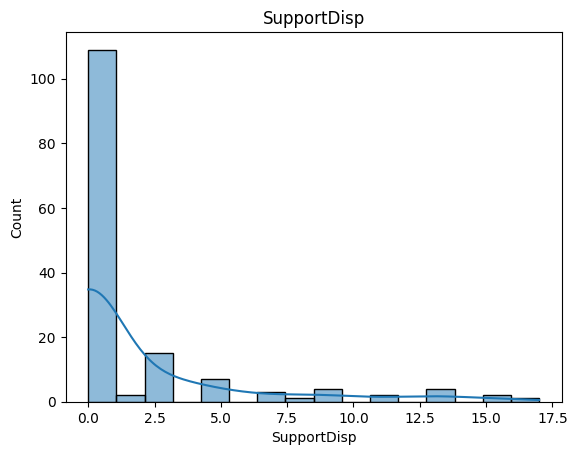

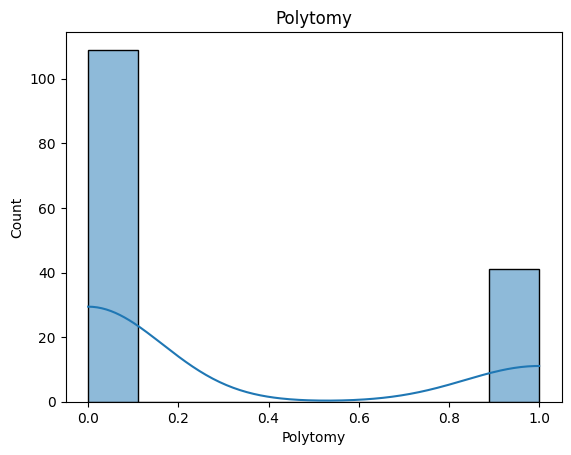

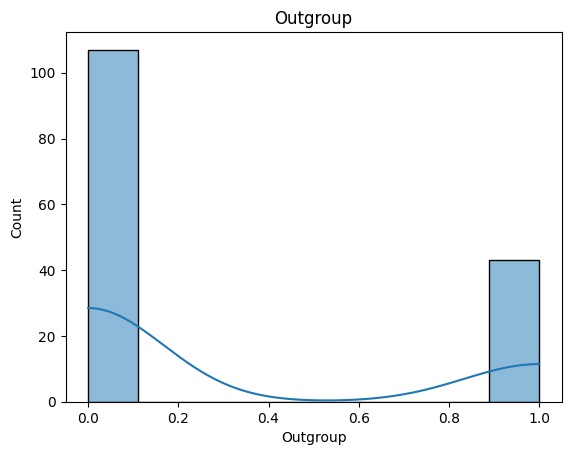

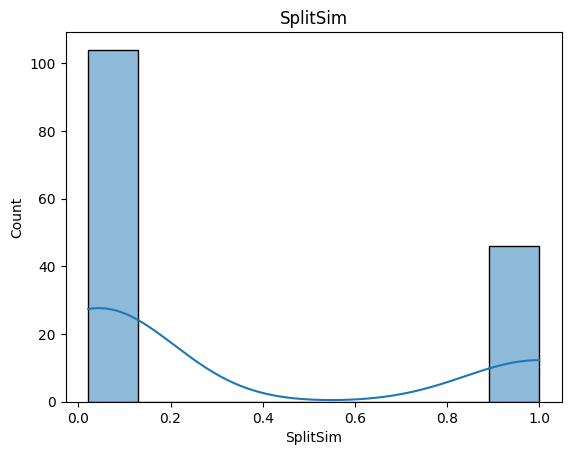

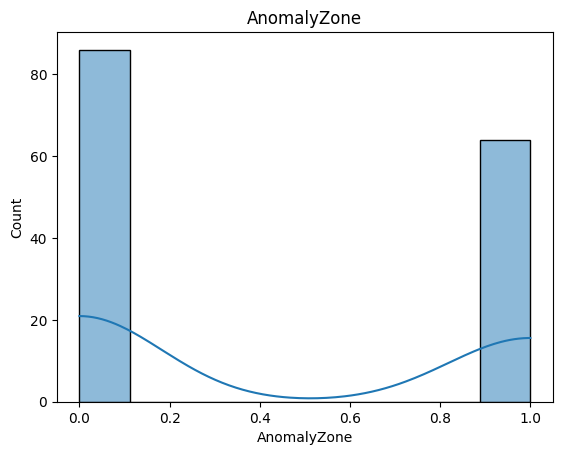

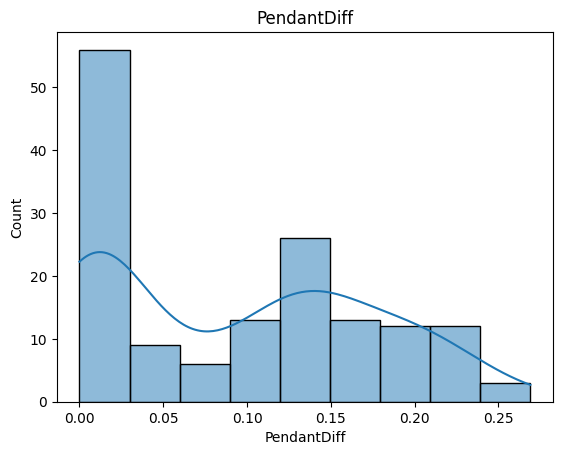

In [13]:
top_var = summary.sort_values('cv', ascending=False).head(6).index

for col in top_var:
    sns.histplot(df[col], kde=True)
    plt.title(col)
    plt.show()

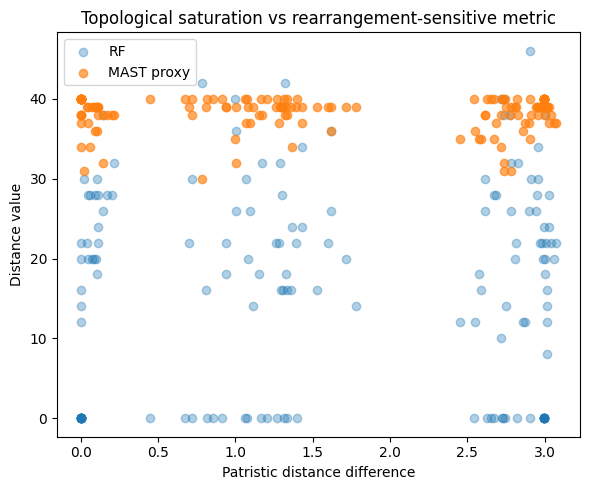

In [71]:
plt.figure(figsize=(6,5))

plt.scatter(df["PatristicDiff"], df["RF"], alpha=0.35, label="RF")
plt.scatter(df["PatristicDiff"], df["MASTproxy"], alpha=0.65, label="MAST proxy")

plt.xlabel("Patristic distance difference")
plt.ylabel("Distance value")
plt.title("Topological saturation vs rearrangement-sensitive metric")
plt.legend()
plt.tight_layout()
plt.show()

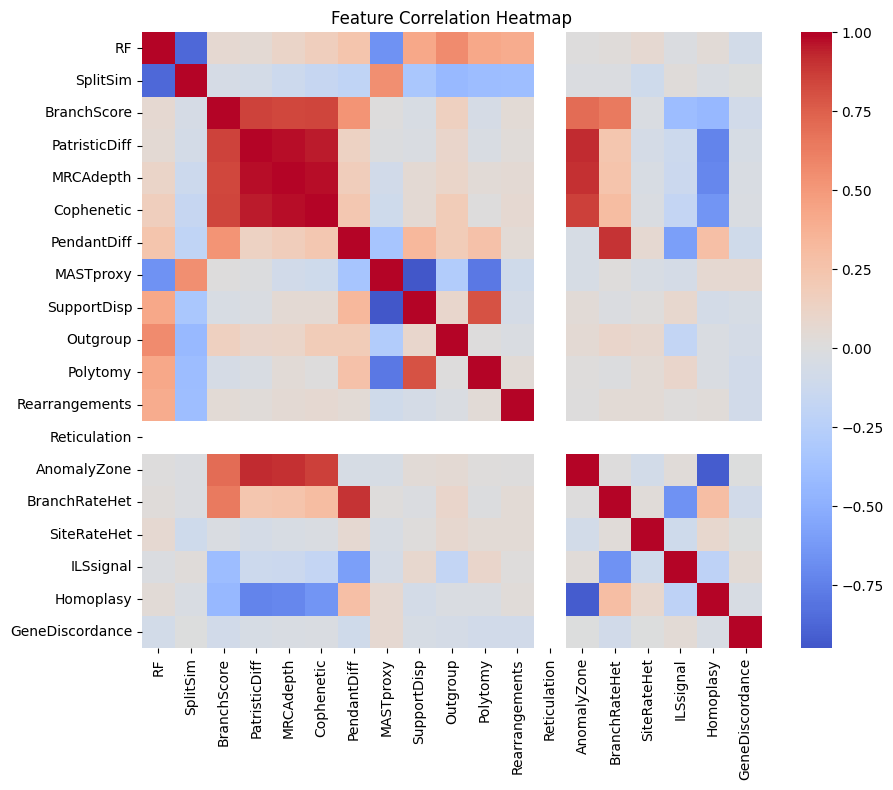

In [14]:
corr = df[feature_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, cmap='coolwarm', center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

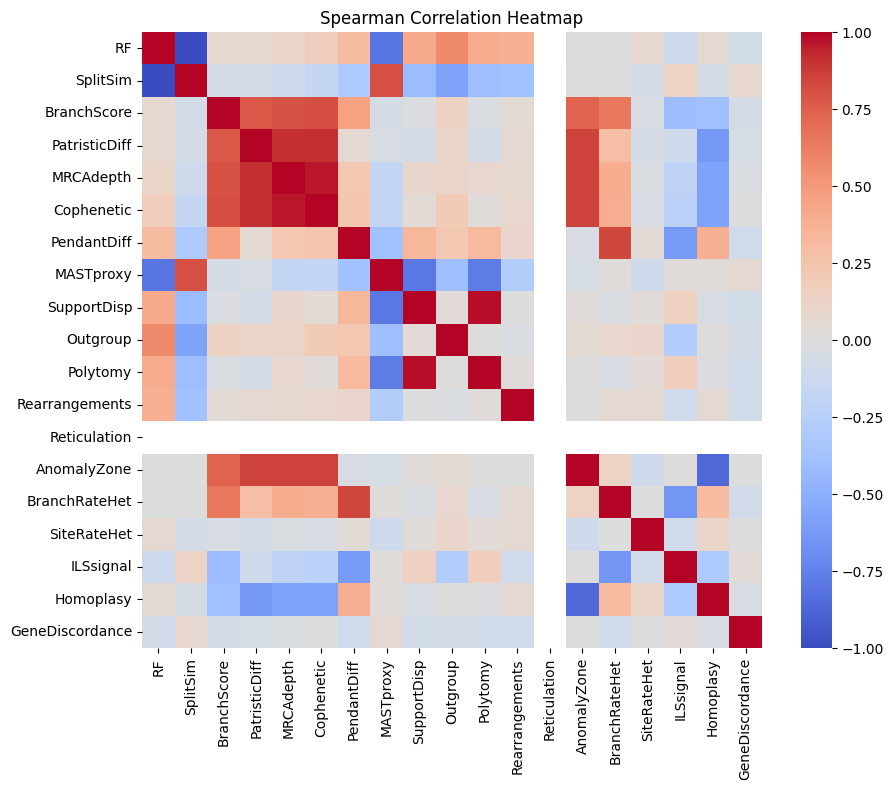

In [15]:
spearman = df[feature_cols].corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(spearman, cmap='coolwarm', center=0)
plt.title("Spearman Correlation Heatmap")
plt.show()

In [16]:
df['HasRearrangement'] = df['Rearrangements'] > 0

rearr_summary = df.groupby('HasRearrangement')[feature_cols].mean().T
rearr_summary['delta'] = rearr_summary[True] - rearr_summary[False]

rearr_summary.sort_values('delta', ascending=False)

HasRearrangement,False,True,delta
RF,11.224490,19.405941,8.181451
Rearrangements,0.000000,1.316832,1.316832
Homoplasy,3.388800,3.858399,0.469599
BranchScore,3.662558,3.756090,0.093531
SiteRateHet,0.890727,0.931816,0.041089
PendantDiff,0.085434,0.098520,0.013086
BranchRateHet,0.143143,0.155841,0.012698
Cophenetic,0.103303,0.108591,0.005289
MRCAdepth,0.214471,0.217886,0.003415
Reticulation,0.000000,0.000000,0.000000


In [17]:
rf0 = df[df['RF'] == 0]
rfpos = df[df['RF'] > 0]

delta_rf = (rfpos[feature_cols].mean() -
            rf0[feature_cols].mean()).sort_values(ascending=False)

delta_rf

,0
RF,24.134615
SupportDisp,2.596154
Rearrangements,0.620401
Outgroup,0.413462
Polytomy,0.394231
BranchScore,0.319514
PatristicDiff,0.179971
Homoplasy,0.133413
SiteRateHet,0.085227
MRCAdepth,0.042529


In [18]:
outgroup_effect = df.groupby('Outgroup')[feature_cols].mean().T
outgroup_effect['delta'] = outgroup_effect[1] - outgroup_effect[0]

outgroup_effect.sort_values('delta', ascending=False)

Outgroup,0,1,delta
RF,12.074766,28.325581,16.250815
Outgroup,0.000000,1.000000,1.000000
BranchScore,3.489058,4.313983,0.824925
SupportDisp,1.588785,2.325581,0.736796
PatristicDiff,1.546138,1.790148,0.244010
SiteRateHet,0.900482,0.962963,0.062481
AnomalyZone,0.411215,0.465116,0.053901
MRCAdepth,0.206348,0.242707,0.036359
PendantDiff,0.084709,0.117973,0.033264
Cophenetic,0.098382,0.127970,0.029588


In [19]:
ils_effect = df.groupby('ILSsignal')[feature_cols].mean().T
ils_effect['delta'] = ils_effect.iloc[:,1] - ils_effect.iloc[:,0]

ils_effect.sort_values('delta', ascending=False)

ILSsignal,0.025,0.025641,0.028571,0.04878,0.05,0.051282,0.055556,0.057143,0.0625,0.073171,...,0.097561,0.1,0.102564,0.105263,0.108108,0.117647,0.121212,0.125,0.128205,delta
SupportDisp,0.000000,1.000000,9.000000,0.000000,0.000000,0.857143,8.000000,9.000000,17.000000,0.000000,...,0.000000,0.000000,0.516129,3.500000,5.000000,13.000000,15.000000,0.000000,2.000000,1.000000
BranchScore,4.345237,5.258290,5.122430,5.050317,4.946490,5.065987,6.841537,5.375726,4.705069,7.926344,...,3.109289,3.278431,2.375517,0.804410,2.084776,1.508146,1.575844,5.673021,3.425299,0.913054
SplitSim,0.046859,0.756620,0.052632,0.032964,0.046886,0.725788,0.053379,0.076923,0.023256,0.028950,...,0.031667,0.050951,0.814274,0.052595,0.060201,0.025641,0.031281,0.043478,0.356322,0.709761
PatristicDiff,1.246485,1.898960,2.571583,1.853034,1.954196,1.778244,2.618295,2.451899,0.782266,2.694632,...,1.538816,1.804210,1.379985,0.314987,1.434607,1.441656,1.402000,2.979919,1.214571,0.652475
AnomalyZone,0.000000,0.500000,1.000000,0.500000,0.363636,0.428571,1.000000,1.000000,0.000000,1.000000,...,0.444444,0.541667,0.419355,0.000000,0.500000,0.500000,0.500000,1.000000,0.333333,0.500000
Polytomy,0.000000,0.250000,1.000000,0.000000,0.000000,0.285714,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,0.193548,1.000000,1.000000,1.000000,1.000000,0.000000,0.666667,0.250000
Rearrangements,0.800000,1.000000,0.000000,1.500000,0.818182,0.571429,1.000000,1.000000,0.000000,1.500000,...,1.444444,1.166667,0.516129,0.500000,0.000000,1.500000,1.000000,1.000000,1.666667,0.200000
MRCAdepth,0.138180,0.246412,0.448029,0.249387,0.260047,0.235746,0.380304,0.429090,0.141828,0.346835,...,0.234352,0.238021,0.173980,0.059924,0.197035,0.270554,0.126762,0.380150,0.147945,0.108232
Cophenetic,0.076632,0.120837,0.197782,0.157839,0.135583,0.112833,0.170056,0.194909,0.125402,0.170104,...,0.122949,0.115318,0.079453,0.030136,0.089508,0.126014,0.080589,0.166635,0.077442,0.044205
ILSsignal,0.025000,0.025641,0.028571,0.048780,0.050000,0.051282,0.055556,0.057143,0.062500,0.073171,...,0.097561,0.100000,0.102564,0.105263,0.108108,0.117647,0.121212,0.125000,0.128205,0.000641


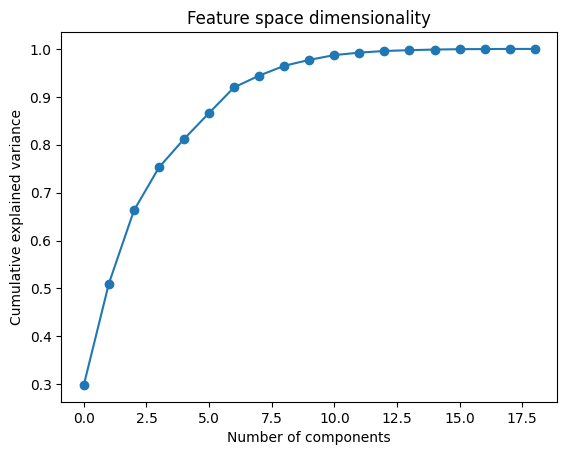

In [20]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = StandardScaler().fit_transform(df[feature_cols])
pca = PCA()
pca.fit(X)

plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.title("Feature space dimensionality")
plt.show()

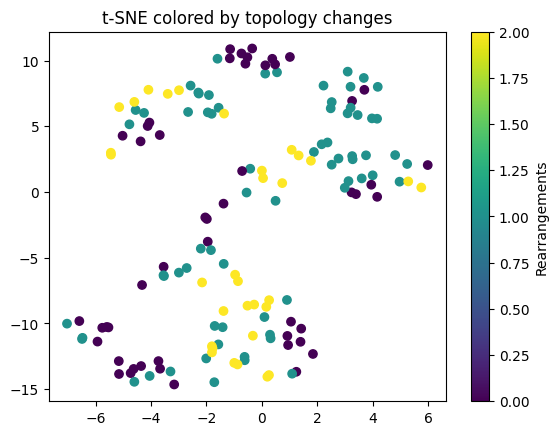

In [21]:
from sklearn.manifold import TSNE

X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

plt.scatter(X_emb[:,0], X_emb[:,1], c=df['Rearrangements'], cmap='viridis')
plt.colorbar(label='Rearrangements')
plt.title("t-SNE colored by topology changes")
plt.show()

In [22]:
'''
PatristicDiff → global structural divergence
Rearrangements → discrete topological edits
Outgroup → global rooting error (binary)
BranchRateHet → evolutionary rate heterogeneity
'''

'\nPatristicDiff → global structural divergence\nRearrangements → discrete topological edits\nOutgroup → global rooting error (binary)\nBranchRateHet → evolutionary rate heterogeneity\n'

In [23]:
import numpy as np

def mean_root_to_leaf(tree):
    """
    Linear-time proxy for global patristic structure.
    """
    return np.mean([
        tree.get_distance(leaf)
        for leaf in tree.get_leaf_names()
    ])


In [24]:
def root_partition_signature(tree):
    """
    Linear-time topology signature capturing major subtree rearrangements.
    """
    root = tree.get_tree_root()
    return sorted([
        len(child.get_leaf_names())
        for child in root.children
    ])

In [25]:
def branch_variance(tree):
    """
    Variance of branch lengths as a proxy for rate heterogeneity.
    """
    return np.var([
        n.dist for n in tree.traverse()
        if n.dist is not None
    ])

In [26]:
def outgroup_misplacement(tree1, tree2, outgroup):
    """
    Detect whether a specified outgroup is placed differently.
    """
    return (
        tree1.get_common_ancestor(outgroup).up !=
        tree2.get_common_ancestor(outgroup).up
    )

In [27]:
# ------------------------------------------------------------
# Normalization functions
# ------------------------------------------------------------

def normalize_patristic(patristic_diff, mean_patristic):
    """
    Normalized patristic distance difference P*
    """
    if mean_patristic == 0:
        return 0.0
    return min(patristic_diff / mean_patristic, 1.0)


def normalize_rearrangements(rearrangements, n_internal_edges=None):
    """
    Rearrangement signal is already normalized (binary).
    """
    return float(rearrangements)

def normalize_branch_rate_het(branch_rate_het, sigma_max):
    """
    Normalized branch-rate heterogeneity.
    """
    if sigma_max == 0:
        return 0.0
    return min(branch_rate_het / sigma_max, 1.0)

In [28]:
# ------------------------------------------------------------
# LIME distance definition (UNCHANGED)
# ------------------------------------------------------------

def LIME_distance(
    patristic_diff,
    rearrangements,
    outgroup_misplaced,
    branch_rate_het,
    mean_patristic_base,
    n_internal_edges,
    sigma_max,
    alpha=1/3,
    beta=1/3,
    gamma=1/3
):

    # --- Normalize components ---
    P_star = normalize_patristic(patristic_diff, mean_patristic_base)
    R_star = normalize_rearrangements(rearrangements, n_internal_edges)
    O_star = 1.0 if outgroup_misplaced else 0.0
    B_star = normalize_branch_rate_het(branch_rate_het, sigma_max)

    # --- Semantic grouping ---
    D_struct = P_star
    D_topo = (R_star + O_star)/2.0
    D_bio = B_star

    # --- Weighted combination ---
    D_lime = (
        alpha * D_struct +
        beta * D_topo +
        gamma * D_bio
    )

    return D_lime


# ------------------------------------------------------------
# Compute all LIME components from two trees
# ------------------------------------------------------------

def compute_LIME_components(T1, T2, outgroup):

    # --- Structural distortion ---
    mean_rl_1 = mean_root_to_leaf(T1)
    mean_rl_2 = mean_root_to_leaf(T2)

    patristic_diff = abs(mean_rl_1 - mean_rl_2)
    mean_patristic_base = mean_rl_1

    # --- Topological disruption ---
    rearrangements = int(
        root_partition_signature(T1) !=
        root_partition_signature(T2)
    )

    # --- Outgroup ---
    og_misplaced = outgroup_misplacement(T1, T2, outgroup)

    # --- Biological heterogeneity ---
    brv_1 = branch_variance(T1)
    brv_2 = branch_variance(T2)

    branch_rate_het = abs(brv_1 - brv_2)
    sigma_max = max(brv_1, brv_2, 1e-6)

    # --- Tree size ---
    n_internal_edges = len(
        [n for n in T1.traverse() if not n.is_leaf()]
    ) - 1

    # --- Final LIME ---
    LIME_value = LIME_distance(
        patristic_diff=patristic_diff,
        rearrangements=rearrangements,
        outgroup_misplaced=og_misplaced,
        branch_rate_het=branch_rate_het,
        mean_patristic_base=mean_patristic_base,
        n_internal_edges=n_internal_edges,
        sigma_max=sigma_max
    )

    return {
        "PatristicStructuralDiff": patristic_diff,
        "RootTopologyDisruption": rearrangements,
        "OutgroupMisplacement": int(og_misplaced),
        "BranchRateHeterogeneity": branch_rate_het,
        "LIME": LIME_value
    }

In [29]:
# ------------------------------------------------------------
# Apply LIME to dataset (NEW, linear-consistent)
# ------------------------------------------------------------

def compute_LIME_for_dataframe(
    df,
    base_tree,
    alpha=1/3,
    beta=1/3,
    gamma=1/3
):
    """
    Compute LIME distance for all rows in a dataframe
    using linear-time component definitions.
    """

    df = df.copy()

    # --- Base tree constants (linear) ---
    mean_patristic_base = mean_root_to_leaf(base_tree)

    n_internal_edges = (
        len([n for n in base_tree.traverse() if not n.is_leaf()]) - 1
    )

    # Conservative normalization for rate heterogeneity
    sigma_max = max(
        df['BranchRateHet'].quantile(0.95),
        1e-6
    )

    # --- Compute LIME row-wise ---
    df['LIME'] = df.apply(
        lambda row: LIME_distance(
            patristic_diff=row['PatristicDiff'],
            rearrangements=row['Rearrangements'],   # already binary
            outgroup_misplaced=row['Outgroup'],
            branch_rate_het=row['BranchRateHet'],
            mean_patristic_base=mean_patristic_base,
            n_internal_edges=n_internal_edges,               # unused but kept for API
            sigma_max=sigma_max,
            alpha=alpha,
            beta=beta,
            gamma=gamma
        ),
        axis=1
    )

    return df


In [30]:
# Assuming your base tree is called T
df = compute_LIME_for_dataframe(df, base_tree=T)

df[['RF', 'LIME']].head()

,RF,LIME
0,0,0.781788
1,18,0.597367
2,22,0.683227
3,0,0.122153
4,0,0.431260


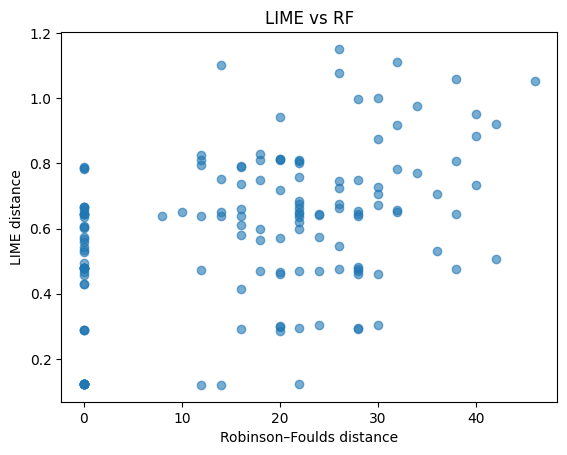

In [31]:
# Distribution check
df['LIME'].describe()

# RF vs LIME
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(df['RF'], df['LIME'], alpha=0.6)
plt.xlabel("Robinson–Foulds distance")
plt.ylabel("LIME distance")
plt.title("LIME vs RF")
plt.show()

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
import dendropy
from dendropy.calculate import treecompare

In [33]:
def branch_score_distance(t1, t2):
    """
    Branch Score Distance (Kuhner–Felsenstein).
    """
    taxa = dendropy.TaxonNamespace(t1.get_leaf_names())

    d1 = dendropy.Tree.get(
        data=t1.write(),
        schema="newick",
        taxon_namespace=taxa
    )
    d2 = dendropy.Tree.get(
        data=t2.write(),
        schema="newick",
        taxon_namespace=taxa
    )

    d1.encode_bipartitions()
    d2.encode_bipartitions()

    return treecompare.branch_score_distance(d1, d2)

In [34]:
from itertools import combinations

def cophenetic_distance(tree):
    leaves = tree.get_leaf_names()
    dist = {}
    for a, b in combinations(leaves, 2):
        ca = tree.get_common_ancestor(a, b)
        dist[(a, b)] = ca.dist
    return dist


def cophenetic_difference(t1, t2):
    c1 = cophenetic_distance(t1)
    c2 = cophenetic_distance(t2)

    keys = set(c1.keys()) & set(c2.keys())
    return np.mean([abs(c1[k] - c2[k]) for k in keys])

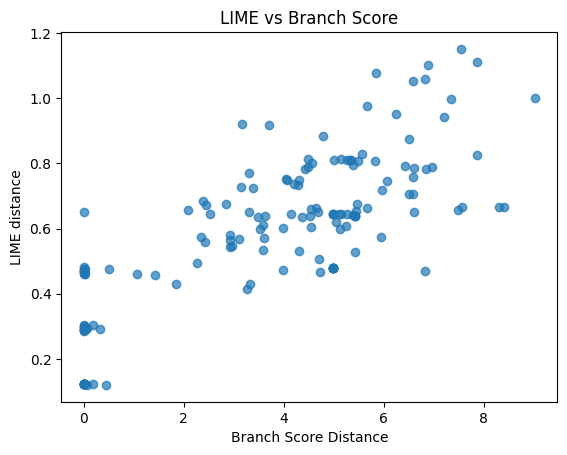

In [35]:
plt.figure()
plt.scatter(df['BranchScore'], df['LIME'], alpha=0.7)
plt.xlabel("Branch Score Distance")
plt.ylabel("LIME distance")
plt.title("LIME vs Branch Score")
plt.show()

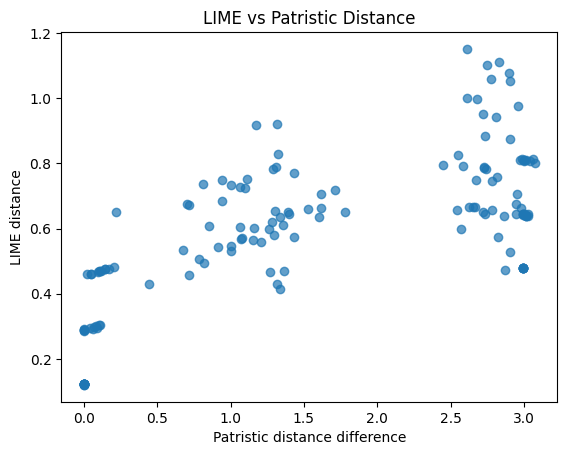

In [36]:
plt.figure()
plt.scatter(df['PatristicDiff'], df['LIME'], alpha=0.7)
plt.xlabel("Patristic distance difference")
plt.ylabel("LIME distance")
plt.title("LIME vs Patristic Distance")
plt.show()

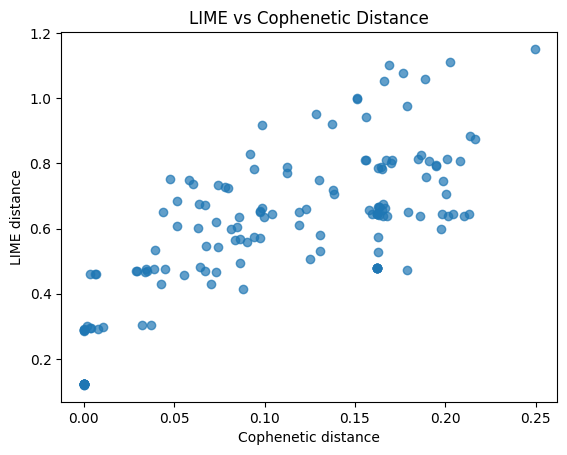

In [37]:
plt.figure()
plt.scatter(df['Cophenetic'], df['LIME'], alpha=0.7)
plt.xlabel("Cophenetic distance")
plt.ylabel("LIME distance")
plt.title("LIME vs Cophenetic Distance")
plt.show()

In [38]:
metrics = {
    "RF": df['RF'],
    "BranchScore": df['BranchScore'],
    "PatristicDiff": df['PatristicDiff'],
    "Cophenetic": df['Cophenetic']
}

for name, series in metrics.items():
    rho, p = spearmanr(series, df['LIME'])
    print(f"LIME vs {name}: Spearman rho = {rho:.3f}, p = {p:.3e}")

LIME vs RF: Spearman rho = 0.399, p = 4.163e-07
LIME vs BranchScore: Spearman rho = 0.742, p = 1.571e-27
LIME vs PatristicDiff: Spearman rho = 0.645, p = 4.971e-19
LIME vs Cophenetic: Spearman rho = 0.720, p = 2.868e-25


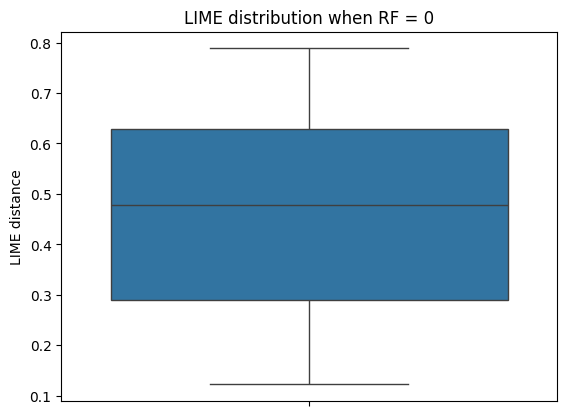

In [39]:
rf_zero = df[df['RF'] == 0]

plt.figure()
sns.boxplot(y=rf_zero['LIME'])
plt.ylabel("LIME distance")
plt.title("LIME distribution when RF = 0")
plt.show()

In [40]:
quantiles = df['LIME'].quantile([0.25, 0.5, 0.75, 0.9])
print(quantiles)

0.25    0.470698
0.50    0.638857
0.75    0.748402
0.90    0.833951
Name: LIME, dtype: float64


In [42]:
def clean_newick(infile, outfile):
    with open(infile, "r") as f:
        s = f.read()
    # remove NHX annotations if present
    s = s.replace("[&R]", "")
    with open(outfile, "w") as f:
        f.write(s)

clean_newick("A1_tree.nwk", "clean_A1.nwk")
clean_newick("A2_tree.nwk", "clean_A2.nwk")


In [43]:
from ete3 import Tree

T_wg = Tree("clean_A1.nwk", format=1, quoted_node_names=True)
T_vp = Tree("clean_A2.nwk", format=1, quoted_node_names=True)

print("Loaded successfully")
print(len(T_wg), len(T_vp))

Loaded successfully
1773 281


In [44]:
s1 = set(T_wg.get_leaf_names())
s2 = set(T_vp.get_leaf_names())

print("Tree 1 taxa:", len(s1))
print("Tree 2 taxa:", len(s2))
print("Common taxa:", len(s1 & s2))

Tree 1 taxa: 1773
Tree 2 taxa: 281
Common taxa: 280


In [45]:
# taxa sets
s1 = set(T_wg.get_leaf_names())
s2 = set(T_vp.get_leaf_names())
common = sorted(list(s1 & s2))

print("Whole-genome taxa:", len(s1))
print("VP1–2B taxa:", len(s2))
print("Common taxa:", len(common))

# prune to intersection (standard & required)
T_wg.prune(common, preserve_branch_length=True)
T_vp.prune(common, preserve_branch_length=True)

print("After pruning:", len(T_wg), len(T_vp))

Whole-genome taxa: 1773
VP1–2B taxa: 281
Common taxa: 280
After pruning: 280 280


In [46]:
import dendropy
from dendropy.calculate import treecompare
shared_taxa = dendropy.TaxonNamespace(T_wg.get_leaf_names())

def to_dendropy_with_namespace(t, taxa):
    return dendropy.Tree.get(
        data=t.write(format=1),
        schema="newick",
        taxon_namespace=taxa
    )

D1 = to_dendropy_with_namespace(T_wg, shared_taxa)
D2 = to_dendropy_with_namespace(T_vp, shared_taxa)

RF = treecompare.symmetric_difference(D1, D2)
BSD = treecompare.euclidean_distance(D1, D2)

print("RF:", RF)
print("Branch Score Distance:", BSD)

RF: 288
Branch Score Distance: 1273.9941130162258


In [47]:
outgroup = T_wg.get_leaf_names()[0]

In [48]:
lime_results = compute_LIME_components(T_wg, T_vp, outgroup)
lime_results

{'PatristicStructuralDiff': np.float64(1170.557142857143),
 'RootTopologyDisruption': 0,
 'OutgroupMisplacement': 0,
 'BranchRateHeterogeneity': np.float64(2899.5912580336),
 'LIME': np.float64(0.6656263916344978)}

In [49]:
import time
import random

def time_lime(tree1, tree2, k):
    leaves = random.sample(tree1.get_leaf_names(), k)

    t1 = tree1.copy()
    t2 = tree2.copy()

    t1.prune(leaves, preserve_branch_length=True)
    t2.prune(leaves, preserve_branch_length=True)

    outgroup = leaves[0]

    start = time.time()
    _ = compute_LIME_components(t1, t2, outgroup)
    end = time.time()

    return end - start

n_leaves = len(T_wg.get_leaf_names())

for k in [50, 100, 200, 400]:
    if k <= n_leaves:
        print(k, time_lime(T_wg, T_vp, k))

50 0.00424504280090332
100 0.01405024528503418
200 0.04595685005187988


In [50]:
import numpy as np
import matplotlib.pyplot as plt

def benchmark_lime(tree1, tree2, sizes, repeats=5):
    results = {}

    for k in sizes:
        times = []
        for _ in range(repeats):
            leaves = random.sample(tree1.get_leaf_names(), k)
            t1 = tree1.copy()
            t2 = tree2.copy()
            t1.prune(leaves, preserve_branch_length=True)
            t2.prune(leaves, preserve_branch_length=True)

            outgroup = leaves[0]

            start = time.time()
            compute_LIME_components(t1, t2, outgroup)
            end = time.time()

            times.append(end - start)

        results[k] = np.mean(times)

    return results

In [51]:
sizes = [50, 100, 150, 200]
results = benchmark_lime(T_wg, T_vp, sizes)

print(results)

{50: np.float64(0.004319334030151367), 100: np.float64(0.01605072021484375), 150: np.float64(0.028130340576171874), 200: np.float64(0.04592418670654297)}


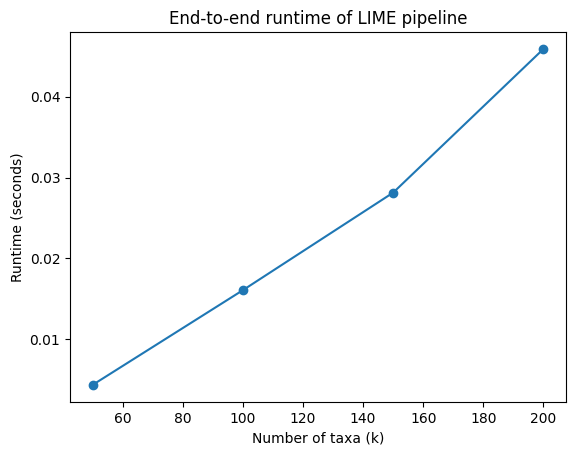

In [52]:
ks = list(results.keys())
times = list(results.values())

plt.figure()
plt.plot(ks, times, marker='o')
plt.xlabel("Number of taxa (k)")
plt.ylabel("Runtime (seconds)")
plt.title("End-to-end runtime of LIME pipeline")
plt.show()

In [54]:
print("After pruning:", len(T_wg), len(T_vp))

After pruning: 280 280


In [58]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 37.4 MB/s eta 0:00:00


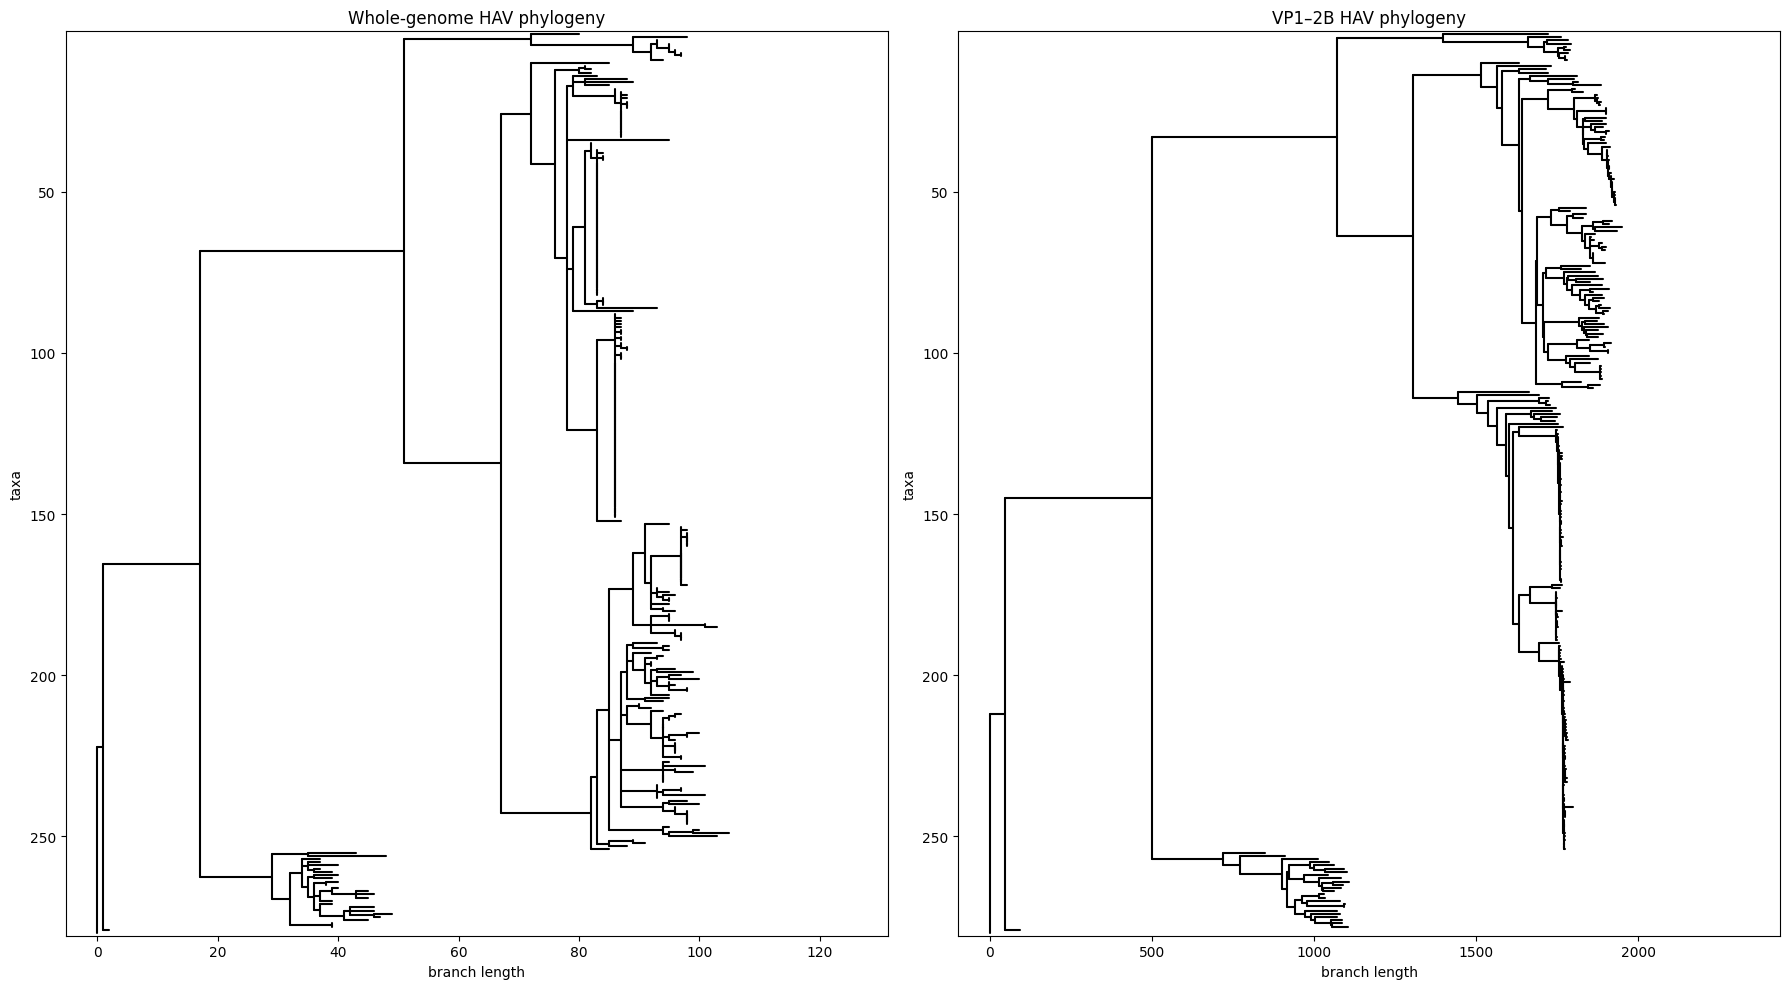

Tree comparison figure saved:
 - hepA_phylogeny_comparison.pdf
 - hepA_phylogeny_comparison.png


In [61]:
from Bio import Phylo
import matplotlib.pyplot as plt

# Save pruned trees to Newick
T_wg.write(outfile="hepA_tree_whole_genome.nwk", format=1)
T_vp.write(outfile="hepA_tree_VP1_2B.nwk", format=1)

# Load with Bio.Phylo
tree_wg = Phylo.read("hepA_tree_whole_genome.nwk", "newick")
tree_vp = Phylo.read("hepA_tree_VP1_2B.nwk", "newick")

# Root both trees on the same outgroup
tree_wg.root_with_outgroup(outgroup)
tree_vp.root_with_outgroup(outgroup)

# Create side-by-side figure
fig, axes = plt.subplots(1, 2, figsize=(18, 10))

Phylo.draw(
    tree_wg,
    axes=axes[0],
    do_show=False,
    show_confidence=False,
    label_func=lambda x: None   # <-- hides leaf labels
)

axes[0].set_title("Whole-genome HAV phylogeny")

Phylo.draw(
    tree_vp,
    axes=axes[1],
    do_show=False,
    show_confidence=False,
    label_func=lambda x: None   # <-- hides leaf labels
)

axes[1].set_title("VP1–2B HAV phylogeny")

plt.tight_layout()
plt.savefig("hepA_phylogeny_comparison.pdf")
plt.savefig("hepA_phylogeny_comparison.png", dpi=300)
plt.show()

print("Tree comparison figure saved:")
print(" - hepA_phylogeny_comparison.pdf")
print(" - hepA_phylogeny_comparison.png")